<a href="https://www.kaggle.com/code/klyushnik/defolt-classification?scriptVersionId=185313346" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries¶

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install ydata-profiling

In [4]:
# from ydata_profiling import ProfileReport

In [5]:
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     StratifiedKFold, 
                                     KFold, StratifiedGroupKFold)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier,  HistGradientBoostingClassifier,
                              GradientBoostingClassifier,RandomForestClassifier,
                             VotingClassifier, StackingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_recall_curve, f1_score)
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import (QuantileTransformer, StandardScaler, 
                                   PowerTransformer, MaxAbsScaler,
                                  MinMaxScaler, RobustScaler,LabelEncoder,
                                   StandardScaler, label_binarize)
from sklearn.calibration import CalibratedClassifierCV

from catboost import CatBoostClassifier

import lightgbm as lgb

import xgboost as xgb

from mlxtend.classifier import StackingCVClassifier 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import itertools
from itertools import combinations

import optuna
from optuna.samplers import TPESampler 

from imblearn.over_sampling import SMOTE

# Dataset Description
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Predict Students' Dropout and Academic Success dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance. Please refer to the original dataset for feature feature explanations.

Files:
- train.csv - the training dataset; Target is the categorical target
- test.csv - the test dataset; your objective is to predict the class of Target for each row
- sample_submission.csv - a sample submission file in the correct format

**Evaluation**
Submissions are evaluated using the accuracy score.


![image-13.png](https://www.nomidl.com/wp-content/uploads/2022/02/image-13.png)

# Load datasets

  ![exam-1-1024x796.jpg](https://www.theopusway.com/wp-content/uploads/2023/07/exam-1-1024x796.jpg)

In [6]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

print(f'Shape our datasets: train {train.shape}, test {test.shape}')

Shape our datasets: train (76518, 38), test (51012, 37)


In [7]:
train.head(5)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [9]:
print('Our target point', train['Target'].unique())

Our target point ['Graduate' 'Dropout' 'Enrolled']


In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,76518.0,38258.500000,22088.988286,0.00,19129.250000,38258.500000,57387.750000,76517.000
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000


# EDA 

In [11]:
# profile = ProfileReport(train, title="Profiling Report")
# profile

- many dataset data are unbalanced;
- Many columns have a large number of 0 values;
- the Nationality column is heavily skewed.

# Mark data and transform

In [12]:
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])

X = train.drop(columns = ['id','Target'])
y = train['Target']
X_total = test.drop(columns = ['id'])

X_df = X.copy(deep = True)
X_df_total = X_total.copy(deep = True)

print('Shape X = ', X.shape, ', shape y = ', y.shape, ' shape X_total = ', X_total.shape)

Shape X =  (76518, 36) , shape y =  (76518,)  shape X_total =  (51012, 36)


In [13]:
target_list = X.columns
target_list

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

# Add features

In [14]:

class AggFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.group_col_name = '_'.join(group_col)      
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.agg_df = None
        self.medians = None
        
    def fit(self, X, y=None):
        self.agg_df = X.groupby(self.group_col)[self.agg_col].agg(self.agg_func)
        self.agg_df.columns = [f'{self.group_col_name}_{agg}_{col}' for col in self.agg_col for agg in self.agg_func]
        return self
    
    def transform(self, X):
        if self.medians is None:
            self.medians = X[self.agg_col].median()
        
        X_merged = X.join(self.agg_df, on=self.group_col, how='left')
        X_merged.fillna(self.medians, inplace=True)
        X_agg = X_merged.loc[:, self.agg_df.columns]
        
        return X_agg
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_agg = self.transform(X)
        return X_agg

class Preprocessor:
    def __init__(self, agg_col, agg_func, group_cols):
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.group_cols = group_cols
        
    def preprocess(self, X, X_total):    
        agg_train, agg_test = [], []
        for group_col in self.group_cols:
            agg_extractor = AggFeatureExtractor(group_col=group_col, agg_col=self.agg_col, agg_func=self.agg_func)
            agg_extractor.fit(pd.concat([X, X_total], axis=0))
            agg_train.append(agg_extractor.transform(X))
            agg_test.append(agg_extractor.transform(X_total))
        X = pd.concat([X] + agg_train, axis=1)
        X_total = pd.concat([X_total] + agg_test, axis=1)
        
        X = X.fillna(0)
        X_total = X_total.fillna(0)
        return X, X_total

In [15]:
agg_col = target_list
agg_func = ['mean', 'std']

group_cols = [['Marital status','Previous qualification'],
              [ 'Application order','Displaced'],
              ['Admission grade','Tuition fees up to date'],
             ['Marital status', 'Application mode', 'Application order'], 
              ['Curricular units 1st sem (credited)',
               'Curricular units 1st sem (enrolled)',
               'Curricular units 1st sem (evaluations)'],
              ['Curricular units 2nd sem (evaluations)',
               'Curricular units 2nd sem (approved)',
               'Curricular units 2nd sem (grade)'],
             ['Daytime/evening attendance',
              'Previous qualification',
              'Previous qualification (grade)',
              'Nacionality'],
              [ 'Unemployment rate',
               'Inflation rate', 
               'GDP'], 
              ['Curricular units 2nd sem (evaluations)',
               'Curricular units 2nd sem (approved)']]

pp = Preprocessor(agg_col, agg_func, group_cols)
X, X_total = pp.preprocess(X, X_total)
print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(76518, 684) , y shape :(76518,), X_test shape :(51012, 684)


In [16]:
for i in target_list:
    X[i+' +log'] = (X[i]+1).transform(np.log)
    X_total[i+' +log'] =(X_total[i]+1).transform(np.log)
######################################################
for i in target_list:
    X[i+'+log1'] = (X[i]+1).transform(np.log1p)
    X_total[i+'+log1'] =(X_total[i]+1).transform(np.log1p)
######################################################
for i in target_list:
    X[i+'+sqrt'] = (X[i]+1).transform(np.sqrt)
    X_total[i+'+sqrt'] =(X_total[i]+1).transform(np.sqrt)
print('Shape X =', X.shape)
print("Shape X_total =", X_total.shape)

Shape X = (76518, 792)
Shape X_total = (51012, 792)


# Polynomial Features labeled

In [17]:
def PolynomialFeatures_labeled(input_df, power):
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    
    for power in powers_nparray[1:]:
        feature_name = " ".join(f"{input_feature_names[i]}^{int(power[i])}" if power[i] != 0 else ""
                                for i in range(len(power)) if power[i] != 0)
        target_feature_names.append(feature_name.replace(" ", " * "))
    
    output_df = pd.DataFrame(output_nparray, columns=target_feature_names)
    return output_df

# Пример использования функции
output_df = PolynomialFeatures_labeled(train[target_list], 2)
output_df_t = PolynomialFeatures_labeled(test[target_list], 2)

In [18]:
X =  pd.concat([X.reset_index(drop=True), output_df], axis = 1)
X_total = pd.concat([X_total.reset_index(drop=True), output_df_t], axis = 1)

print('Shape train =', X.shape)
print('Shape test =', X_total.shape)

Shape train = (76518, 1495)
Shape test = (51012, 1495)


In [19]:
X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_total = X_total.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(76518, 1495) , y shape :(76518,), X_test shape :(51012, 1495)


# Threshold

In [20]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

In [21]:
X = variance_threshold(X,0.002)
list_name = (X.columns)
X_total = X_total[list_name]

print(f"X shape :{X.shape} , y shape :{y.shape}, X_test shape :{X_total.shape}")

X shape :(76518, 1395) , y shape :(76518,), X_test shape :(51012, 1395)


# PCA

In [22]:
pca = PCA(n_components=2)
pca.fit(X)

principalComponents = pca.transform(X)
principalComponents_test = pca.transform(X_total)

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2'])
principalDftest = pd.DataFrame(data = principalComponents_test,
                               columns = ['principal component 1', 'principal component 2'])

X = pd.concat([X_df, principalDf], axis = 1)
X_total = pd.concat([X_df_total.reset_index(drop=True), principalDftest], axis = 1)

print('Shape train is', X.shape, 'Shape test is', X_total.shape)

Shape train is (76518, 38) Shape test is (51012, 38)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Shape train X {X_train.shape}, y {y_train.shape}, test X {X_test.shape}, y {y_test.shape}')

Shape train X (53562, 38), y (53562,), test X (22956, 38), y (22956,)


# Optuna

In [24]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()

In [25]:
def objective(trial):
    param = {'iterations' :trial.suggest_int("iterations", 100, 1300),
        'learning_rate' :trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'colsample_bylevel'  :trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        'min_data_in_leaf' :trial.suggest_int("min_data_in_leaf", 1, 100),
        'depth' : trial.suggest_int("depth", 4, 15),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
        'border_count': trial.suggest_int("border_count", 1, 255),
        'grow_policy': trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        'leaf_estimation_method': trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        'leaf_estimation_iterations': trial.suggest_int("leaf_estimation_iterations", 1, 10),
        'leaf_estimation_backtracking': trial.suggest_categorical("leaf_estimation_backtracking", ["No", "AnyImprovement"]),
            }
    model = CatBoostClassifier(**param, verbose = 0)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=35)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-25 05:38:30,924] A new study created in memory with name: no-name-642ad5b0-9843-4473-b3d9-f687a5bde42f
[I 2024-06-25 05:39:29,425] Trial 0 finished with value: 0.8263634779578324 and parameters: {'iterations': 780, 'learning_rate': 0.01566487223261222, 'colsample_bylevel': 0.4917814856798507, 'min_data_in_leaf': 76, 'depth': 10, 'l2_leaf_reg': 5.2774652129482976e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0021958884628739267, 'bagging_temperature': 9.244033584442825, 'od_type': 'IncToDec', 'od_wait': 26, 'border_count': 239, 'grow_policy': 'Lossguide', 'leaf_estimation_method': 'Gradient', 'leaf_estimation_iterations': 7, 'leaf_estimation_backtracking': 'AnyImprovement'}. Best is trial 0 with value: 0.8263634779578324.
[I 2024-06-25 05:40:49,452] Trial 1 finished with value: 0.8295434744729047 and parameters: {'iterations': 957, 'learning_rate': 0.016910688494872917, 'colsample_bylevel': 0.9762311452545119, 'min_data_in_leaf': 56, 'depth': 15, 'l2_leaf_reg': 0.05

Number of finished trials: 35
Best trial:
  Value: 0.8379508625196027
  Params: 
    iterations: 1288
    learning_rate: 0.04969223434367023
    colsample_bylevel: 0.674470721526955
    min_data_in_leaf: 41
    depth: 5
    l2_leaf_reg: 0.21572516896148874
    bootstrap_type: Bayesian
    random_strength: 0.004813766703459625
    bagging_temperature: 0.7748073910326188
    od_type: IncToDec
    od_wait: 40
    border_count: 187
    grow_policy: SymmetricTree
    leaf_estimation_method: Gradient
    leaf_estimation_iterations: 6
    leaf_estimation_backtracking: AnyImprovement


              precision    recall  f1-score   support

           0       0.91      0.84      0.87      7579
           1       0.66      0.62      0.64      4425
           2       0.86      0.93      0.89     10952

    accuracy                           0.84     22956
   macro avg       0.81      0.79      0.80     22956
weighted avg       0.84      0.84      0.84     22956



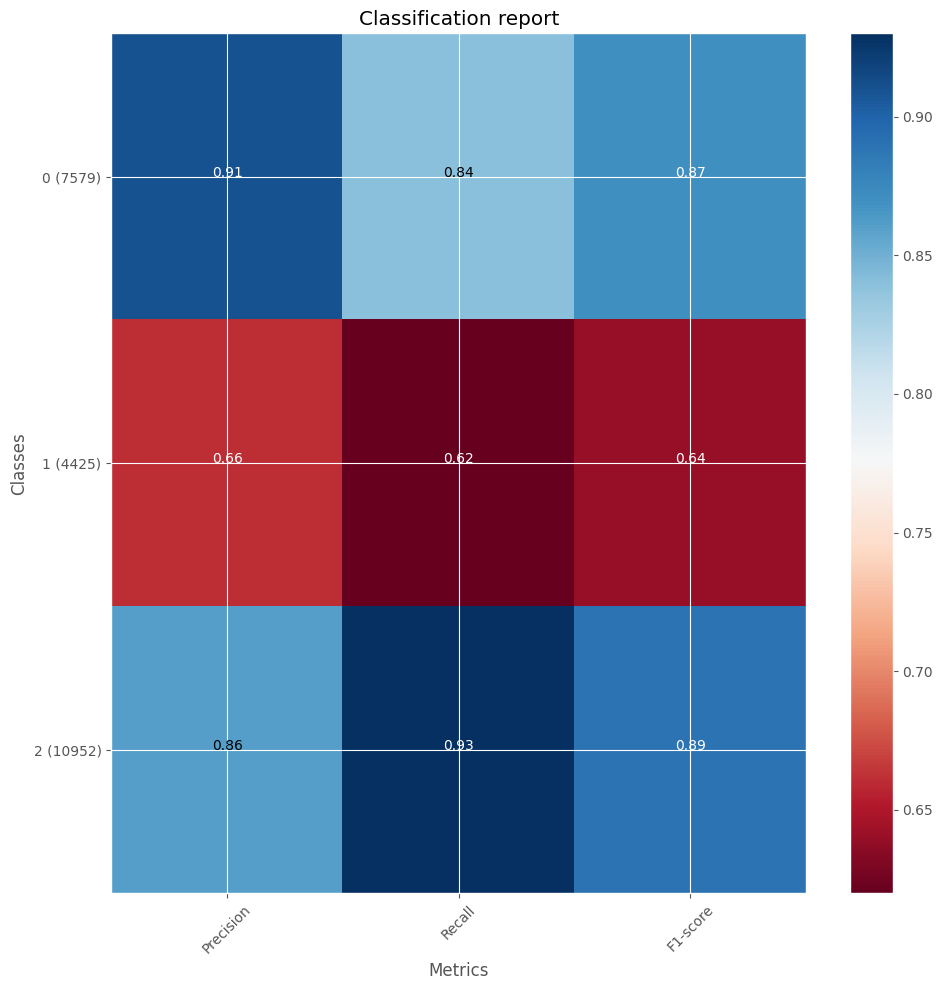

In [26]:
ct_best_params = study.best_params
model_ct = CatBoostClassifier(**ct_best_params,verbose = 0)
model_ct.fit(X_train, y_train)

y_pred = model_ct.predict(X_test)
clf = classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)              

In [27]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'verbose' : -1,
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 1e3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "eval_set": [(X_test, y_test)],
    }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=35)

print('Best parameters:', study.best_params)
print('Best value:', study.best_value)
print('Best trial:', study.best_trial)

[I 2024-06-25 06:18:19,321] A new study created in memory with name: lightgbm
[I 2024-06-25 06:18:39,368] Trial 0 finished with value: 0.8323314166231051 and parameters: {'max_depth': 6, 'min_split_gain': 0.7203244934421581, 'min_child_weight': 0.0010015813955858968, 'subsample': 0.6511662863159199, 'subsample_freq': 1, 'lambda_l1': 6.777153976882678e-08, 'lambda_l2': 4.746154837062843e-07, 'n_estimators': 551, 'num_leaves': 103, 'feature_fraction': 0.7232900404020142, 'bagging_fraction': 0.6515167086419769, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 0 with value: 0.8323314166231051.
[I 2024-06-25 06:20:24,633] Trial 1 finished with value: 0.8263199163617355 and parameters: {'max_depth': 13, 'min_split_gain': 0.027387593197926163, 'min_child_weight': 10.539137268289434, 'subsample': 0.7086524011835635, 'subsample_freq': 4, 'lambda_l1': 1.8343510276558088e-07, 'lambda_l2': 6.066153585423825e-07, 'n_estimators': 1211, 'num_leaves': 248, 'feature_fraction': 0.5880545068955

Best parameters: {'max_depth': -1, 'min_split_gain': 0.28258868280721355, 'min_child_weight': 0.05440651214220967, 'subsample': 0.5196510530880276, 'subsample_freq': 2, 'lambda_l1': 0.00959525009157795, 'lambda_l2': 0.09913157411439621, 'n_estimators': 966, 'num_leaves': 6, 'feature_fraction': 0.41767913341038054, 'bagging_fraction': 0.9978831755987974, 'bagging_freq': 3, 'min_child_samples': 52}
Best value: 0.8382993552883777
Best trial: FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.8382993552883777], datetime_start=datetime.datetime(2024, 6, 25, 6, 25, 2, 422882), datetime_complete=datetime.datetime(2024, 6, 25, 6, 25, 41, 100816), params={'max_depth': -1, 'min_split_gain': 0.28258868280721355, 'min_child_weight': 0.05440651214220967, 'subsample': 0.5196510530880276, 'subsample_freq': 2, 'lambda_l1': 0.00959525009157795, 'lambda_l2': 0.09913157411439621, 'n_estimators': 966, 'num_leaves': 6, 'feature_fraction': 0.41767913341038054, 'bagging_fraction': 0.9978831755987974

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      7579
           1       0.66      0.62      0.64      4425
           2       0.86      0.92      0.89     10952

    accuracy                           0.84     22956
   macro avg       0.81      0.80      0.80     22956
weighted avg       0.84      0.84      0.84     22956



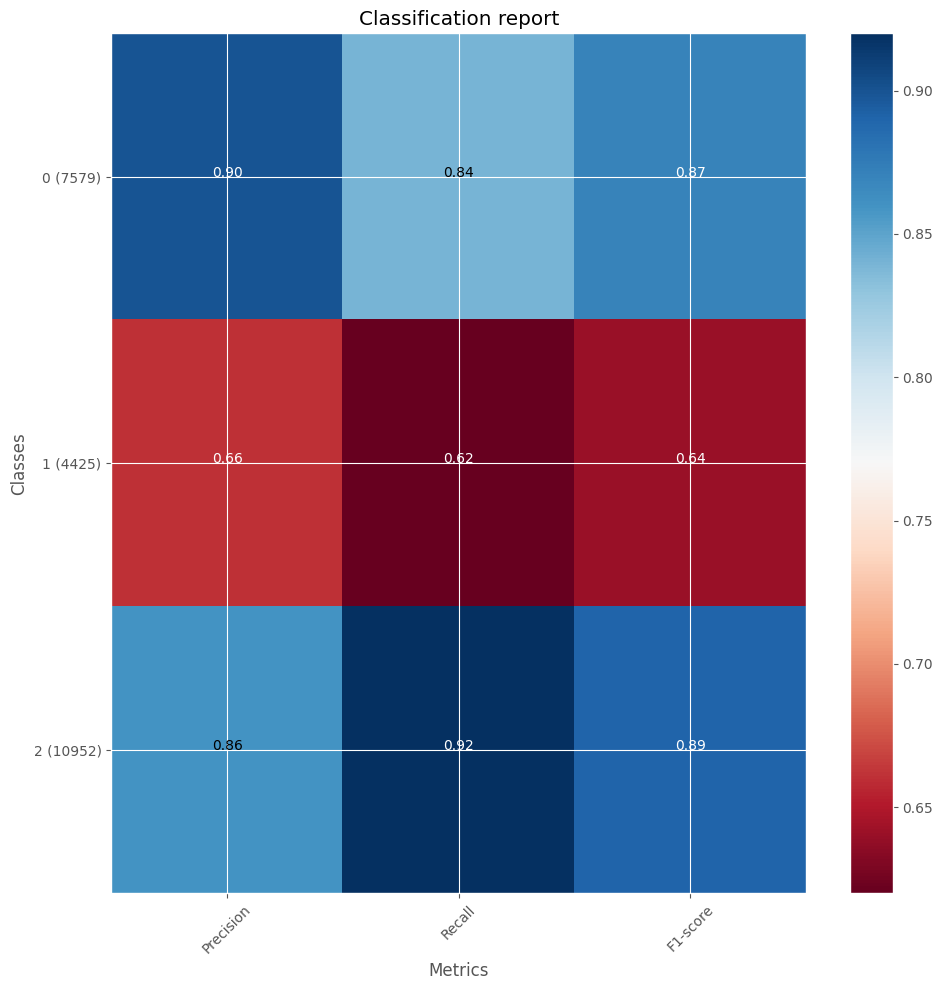

In [28]:
lgb_best_params = study.best_params
model_lgb = lgb.LGBMClassifier(**lgb_best_params, verbose = -1)
model_lgb.fit(X_train, y_train)
y_pred = model_lgb.predict(X_test)
clf =classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

In [29]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 100.0),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=35)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-06-25 06:40:56,101] A new study created in memory with name: no-name-e697d1ef-337b-47b6-a497-fbbab3a0cbc1
[I 2024-06-25 06:42:36,060] Trial 0 finished with value: 0.8345966196201429 and parameters: {'max_depth': 13, 'learning_rate': 0.01936144824090806, 'n_estimators': 1075, 'min_child_weight': 10, 'gamma': 2.2332276952270873e-06, 'subsample': 0.0473249463000241, 'colsample_bytree': 0.1863351220255119, 'reg_alpha': 0.5122616407036819, 'reg_lambda': 0.0004515046626974323, 'scale_pos_weight': 28.658457228490807, 'max_delta_step': 9.206181676575405}. Best is trial 0 with value: 0.8345966196201429.
[I 2024-06-25 06:43:51,613] Trial 1 finished with value: 0.8347273044084336 and parameters: {'max_depth': 5, 'learning_rate': 0.049620897523051474, 'n_estimators': 1223, 'min_child_weight': 8, 'gamma': 6.949402270224381e-05, 'subsample': 0.31412890847740116, 'colsample_bytree': 0.8702176520670605, 'reg_alpha': 1.2986820679926308e-07, 'reg_lambda': 2.926749648809258e-05, 'scale_pos_weight

Number of finished trials: 35
Best trial:
  Value: 0.8383864784805716
  Params: 
    max_depth: 7
    learning_rate: 0.024569295574637252
    n_estimators: 1112
    min_child_weight: 4
    gamma: 1.0304235430019246e-08
    subsample: 0.6701461403157707
    colsample_bytree: 0.18822848078893265
    reg_alpha: 6.0215354212537934e-06
    reg_lambda: 4.293472351710488e-07
    scale_pos_weight: 8.154375635678967
    max_delta_step: 3.2068845276901166


              precision    recall  f1-score   support

           0       0.91      0.84      0.87      7579
           1       0.66      0.63      0.64      4425
           2       0.86      0.92      0.89     10952

    accuracy                           0.84     22956
   macro avg       0.81      0.80      0.80     22956
weighted avg       0.84      0.84      0.84     22956



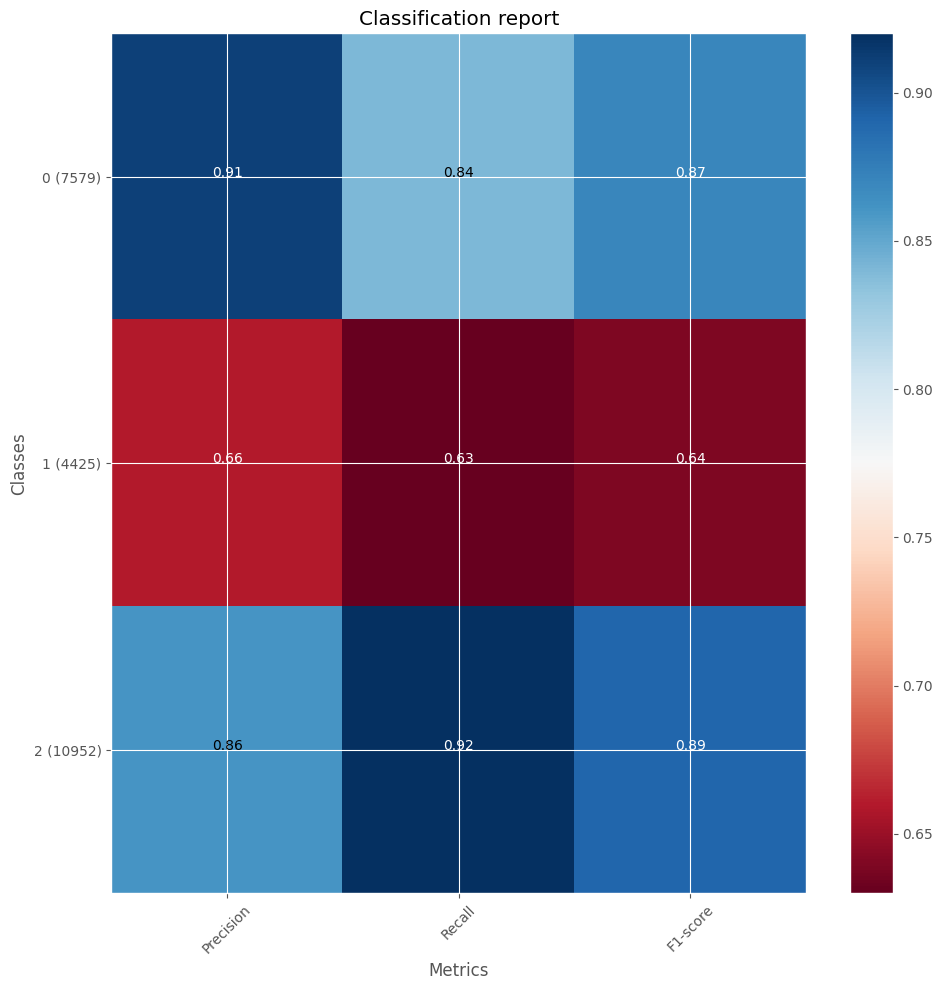

In [30]:
xgb_best = study.best_params
model_xgb = xgb.XGBClassifier(**xgb_best)
model_xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=200,verbose=False)
y_pred = model_xgb.predict(X_test)
clf =classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

In [31]:
def objective(trial):
    # Ваши параметры
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
        "max_features": trial.suggest_categorical("max_features", ['auto', 'sqrt']),
        "max_depth": trial.suggest_int("max_depth", 10, 110, step=20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, step=1),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 1000, step=10) or None,
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"])
    }
    
    # Модель
    optuna_model = RandomForestClassifier(random_state=42, **params)
    
    # Кросс-валидация
    scores = cross_val_score(optuna_model, X_train, y_train, cv=5)
    
    # Средняя точность
    accuracy = scores.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=35, n_jobs=-1)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value:', trial.value)
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-25 07:21:57,422] A new study created in memory with name: no-name-ad0d29d3-f3ba-4fc9-909c-4d3055d13db9
[I 2024-06-25 07:25:08,297] Trial 3 finished with value: 0.7992607064055055 and parameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'gini', 'max_leaf_nodes': 60, 'class_weight': 'balanced_subsample'}. Best is trial 3 with value: 0.7992607064055055.
[I 2024-06-25 07:30:51,807] Trial 0 finished with value: 0.8160636533043164 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'gini', 'max_leaf_nodes': 70, 'class_weight': None}. Best is trial 0 with value: 0.8160636533043164.
[I 2024-06-25 07:33:49,817] Trial 2 finished with value: 0.8179680316928047 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf'

Number of finished trials: 35
Best trial:
  Value: 0.8220006794143652
    n_estimators: 200
    max_features: auto
    max_depth: 70
    min_samples_split: 10
    min_samples_leaf: 4
    bootstrap: True
    criterion: entropy
    max_leaf_nodes: 970
    class_weight: None


              precision    recall  f1-score   support

           0       0.90      0.82      0.86      7579
           1       0.65      0.59      0.62      4425
           2       0.85      0.93      0.89     10952

    accuracy                           0.83     22956
   macro avg       0.80      0.78      0.79     22956
weighted avg       0.83      0.83      0.83     22956



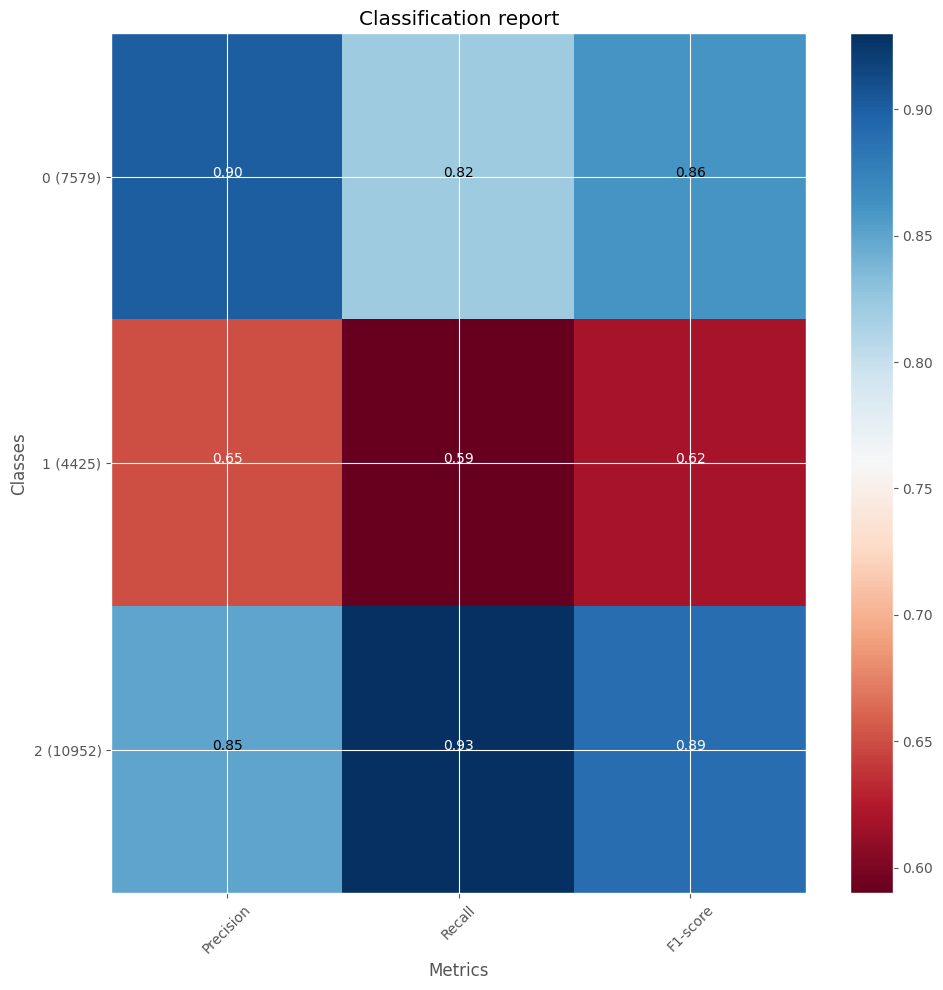

In [32]:
rf_best = study.best_params
model_rd = RandomForestClassifier(random_state=42, **rf_best)
model_rd.fit(X_train,y_train)
y_pred = model_rd.predict(X_test)
clf = classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

# Compare ensemble of ensemble

In [33]:
def create_calibrated_classifier(base_model, method='sigmoid', n_splits=5, random_state=42):
    return CalibratedClassifierCV(
        base_model,
        method=method,
        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    )

level_0 = [
    ('cat', CatBoostClassifier(**ct_best_params, verbose=0)),
    ('lgb', lgb.LGBMClassifier(**lgb_best_params, verbose=-1)),
    ('calib_lgb', create_calibrated_classifier(lgb.LGBMClassifier(**lgb_best_params, verbose=-1))),
    ('calib_cat', create_calibrated_classifier(CatBoostClassifier(**ct_best_params, verbose=0)))
]

final_estimator_0 = lgb.LGBMClassifier(**lgb_best_params, verbose=-1)

stack_0 = StackingClassifier(estimators=level_0, final_estimator=final_estimator_0, cv=5)

level_1 = [
    ('xgb', xgb.XGBClassifier(**xgb_best)),
    ('rf', RandomForestClassifier(**rf_best)),
    ('calib_xgb', create_calibrated_classifier(xgb.XGBClassifier(**xgb_best))),
    ('calib_rf', create_calibrated_classifier(RandomForestClassifier(**rf_best)))
]

final_estimator_1 = CatBoostClassifier(**ct_best_params, verbose=0)

stack_1 = StackingClassifier(estimators=level_1, final_estimator=final_estimator_1, cv=5)

level_2 = [
    ('cat', CatBoostClassifier(**ct_best_params, verbose=0)),
    ('lgb', lgb.LGBMClassifier(**lgb_best_params, verbose=-1)),
    ('xgb', xgb.XGBClassifier(**xgb_best)),
    ('calib_lgb', create_calibrated_classifier(lgb.LGBMClassifier(**lgb_best_params, verbose=-1))),
    ('calib_cat', create_calibrated_classifier(CatBoostClassifier(**ct_best_params, verbose=0))),
    ('calib_xgb', create_calibrated_classifier(xgb.XGBClassifier(**xgb_best)))
]

final_estimator_2 = xgb.XGBClassifier(**xgb_best)

stack_2 = StackingClassifier(estimators=level_2, final_estimator=final_estimator_2, cv=5)


ensemble = VotingClassifier(estimators=[
    ('stack_0', stack_0),
    ('stack_1', stack_1),
    ('stack_2', stack_2)
], voting='soft')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8377


# Predict and Submit

In [34]:
prediction = ensemble.predict(X_total)

In [35]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
sub['Target'] = le.inverse_transform(prediction)
sub.to_csv('submission.csv', index=False)
sub.head(5)

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
